In [1]:
import tensorflow as tf
import sys
import math
import os
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import tarfile
from six.moves import urllib

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.ops import control_flow_ops
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.python.platform import gfile
from progress.bar import Bar

In [2]:
LABELS_FILENAME = 'labels.txt'


def int64_feature(values):
  """Returns a TF-Feature of int64s.

  Args:
    values: A scalar or list of values.

  Returns:
    a TF-Feature.
  """
  if not isinstance(values, (tuple, list)):
    values = [values]
  return tf.train.Feature(int64_list=tf.train.Int64List(value=values))


def bytes_feature(values):
  """Returns a TF-Feature of bytes.

  Args:
    values: A string.

  Returns:
    a TF-Feature.
  """
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))


def image_to_tfexample(image_data, image_format, height, width, class_id):
  return tf.train.Example(features=tf.train.Features(feature={
      'image/encoded': bytes_feature(image_data),
      'image/format': bytes_feature(image_format),
      'image/class/label': int64_feature(class_id),
      'image/height': int64_feature(height),
      'image/width': int64_feature(width),
  }))


def download_and_uncompress_tarball(tarball_url, dataset_dir):
  """Downloads the `tarball_url` and uncompresses it locally.

  Args:
    tarball_url: The URL of a tarball file.
    dataset_dir: The directory where the temporary files are stored.
  """
  filename = tarball_url.split('/')[-1]
  filepath = os.path.join(dataset_dir, filename)

  def _progress(count, block_size, total_size):
    sys.stdout.write('\r>> Downloading %s %.1f%%' % (
        filename, float(count * block_size) / float(total_size) * 100.0))
    sys.stdout.flush()
  filepath, _ = urllib.request.urlretrieve(tarball_url, filepath, _progress)
  print()
  statinfo = os.stat(filepath)
  print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(dataset_dir)


def write_label_file(labels_to_class_names, dataset_dir,
                     filename=LABELS_FILENAME):
  """Writes a file with the list of class names.

  Args:
    labels_to_class_names: A map of (integer) labels to class names.
    dataset_dir: The directory in which the labels file should be written.
    filename: The filename where the class names are written.
  """
  labels_filename = os.path.join(dataset_dir, filename)
  with tf.gfile.Open(labels_filename, 'w') as f:
    for label in labels_to_class_names:
      class_name = labels_to_class_names[label]
      f.write('%d:%s\n' % (label, class_name))


def has_labels(dataset_dir, filename=LABELS_FILENAME):
  """Specifies whether or not the dataset directory contains a label map file.

  Args:
    dataset_dir: The directory in which the labels file is found.
    filename: The filename where the class names are written.

  Returns:
    `True` if the labels file exists and `False` otherwise.
  """
  return tf.gfile.Exists(os.path.join(dataset_dir, filename))


def read_label_file(dataset_dir, filename=LABELS_FILENAME):
  """Reads the labels file and returns a mapping from ID to class name.

  Args:
    dataset_dir: The directory in which the labels file is found.
    filename: The filename where the class names are written.

  Returns:
    A map from a label (integer) to class name.
  """
  labels_filename = os.path.join(dataset_dir, filename)
  with tf.gfile.Open(labels_filename, 'r') as f:
    lines = f.read().decode()
  lines = lines.split('\n')
  lines = filter(None, lines)

  labels_to_class_names = {}
  for line in lines:
    index = line.index(':')
    labels_to_class_names[int(line[:index])] = line[index+1:]
  return labels_to_class_names


In [3]:
slim = tf.contrib.slim


def inception_arg_scope(weight_decay=0.00004,
                        use_batch_norm=True,
                        batch_norm_decay=0.9997,
                        batch_norm_epsilon=0.001):
  """Defines the default arg scope for inception models.

  Args:
    weight_decay: The weight decay to use for regularizing the model.
    use_batch_norm: "If `True`, batch_norm is applied after each convolution.
    batch_norm_decay: Decay for batch norm moving average.
    batch_norm_epsilon: Small float added to variance to avoid dividing by zero
      in batch norm.

  Returns:
    An `arg_scope` to use for the inception models.
  """
  batch_norm_params = {
      # Decay for the moving averages.
      'decay': batch_norm_decay,
      # epsilon to prevent 0s in variance.
      'epsilon': batch_norm_epsilon,
      # collection containing update_ops.
      'updates_collections': tf.GraphKeys.UPDATE_OPS,
  }
  if use_batch_norm:
    normalizer_fn = slim.batch_norm
    normalizer_params = batch_norm_params
  else:
    normalizer_fn = None
    normalizer_params = {}
  # Set weight_decay for weights in Conv and FC layers.
  with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      weights_regularizer=slim.l2_regularizer(weight_decay)):
    with slim.arg_scope(
        [slim.conv2d],
        weights_initializer=slim.variance_scaling_initializer(),
        activation_fn=tf.nn.relu,
        normalizer_fn=normalizer_fn,
        normalizer_params=normalizer_params) as sc:
      return sc

In [4]:
slim = tf.contrib.slim
trunc_normal = lambda stddev: tf.truncated_normal_initializer(0.0, stddev)


def inception_v3_base(inputs,
                      final_endpoint='Mixed_7c',
                      min_depth=16,
                      depth_multiplier=1.0,
                      scope=None):
  """Inception model from http://arxiv.org/abs/1512.00567.

  Constructs an Inception v3 network from inputs to the given final endpoint.
  This method can construct the network up to the final inception block
  Mixed_7c.

  Note that the names of the layers in the paper do not correspond to the names
  of the endpoints registered by this function although they build the same
  network.

  Here is a mapping from the old_names to the new names:
  Old name          | New name
  =======================================
  conv0             | Conv2d_1a_3x3
  conv1             | Conv2d_2a_3x3
  conv2             | Conv2d_2b_3x3
  pool1             | MaxPool_3a_3x3
  conv3             | Conv2d_3b_1x1
  conv4             | Conv2d_4a_3x3
  pool2             | MaxPool_5a_3x3
  mixed_35x35x256a  | Mixed_5b
  mixed_35x35x288a  | Mixed_5c
  mixed_35x35x288b  | Mixed_5d
  mixed_17x17x768a  | Mixed_6a
  mixed_17x17x768b  | Mixed_6b
  mixed_17x17x768c  | Mixed_6c
  mixed_17x17x768d  | Mixed_6d
  mixed_17x17x768e  | Mixed_6e
  mixed_8x8x1280a   | Mixed_7a
  mixed_8x8x2048a   | Mixed_7b
  mixed_8x8x2048b   | Mixed_7c

  Args:
    inputs: a tensor of size [batch_size, height, width, channels].
    final_endpoint: specifies the endpoint to construct the network up to. It
      can be one of ['Conv2d_1a_3x3', 'Conv2d_2a_3x3', 'Conv2d_2b_3x3',
      'MaxPool_3a_3x3', 'Conv2d_3b_1x1', 'Conv2d_4a_3x3', 'MaxPool_5a_3x3',
      'Mixed_5b', 'Mixed_5c', 'Mixed_5d', 'Mixed_6a', 'Mixed_6b', 'Mixed_6c',
      'Mixed_6d', 'Mixed_6e', 'Mixed_7a', 'Mixed_7b', 'Mixed_7c'].
    min_depth: Minimum depth value (number of channels) for all convolution ops.
      Enforced when depth_multiplier < 1, and not an active constraint when
      depth_multiplier >= 1.
    depth_multiplier: Float multiplier for the depth (number of channels)
      for all convolution ops. The value must be greater than zero. Typical
      usage will be to set this value in (0, 1) to reduce the number of
      parameters or computation cost of the model.
    scope: Optional variable_scope.

  Returns:
    tensor_out: output tensor corresponding to the final_endpoint.
    end_points: a set of activations for external use, for example summaries or
                losses.

  Raises:
    ValueError: if final_endpoint is not set to one of the predefined values,
                or depth_multiplier <= 0
  """
  # end_points will collect relevant activations for external use, for example
  # summaries or losses.
  end_points = {}

  if depth_multiplier <= 0:
    raise ValueError('depth_multiplier is not greater than zero.')
  depth = lambda d: max(int(d * depth_multiplier), min_depth)

  with tf.variable_scope(scope, 'InceptionV3', [inputs]):
    with slim.arg_scope([slim.conv2d, slim.max_pool2d, slim.avg_pool2d],
                        stride=1, padding='VALID'):
      # 299 x 299 x 3
      end_point = 'Conv2d_1a_3x3'
      net = slim.conv2d(inputs, depth(32), [3, 3], stride=2, scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 149 x 149 x 32
      end_point = 'Conv2d_2a_3x3'
      net = slim.conv2d(net, depth(32), [3, 3], scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 147 x 147 x 32
      end_point = 'Conv2d_2b_3x3'
      net = slim.conv2d(net, depth(64), [3, 3], padding='SAME', scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 147 x 147 x 64
      end_point = 'MaxPool_3a_3x3'
      net = slim.max_pool2d(net, [3, 3], stride=2, scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 73 x 73 x 64
      end_point = 'Conv2d_3b_1x1'
      net = slim.conv2d(net, depth(80), [1, 1], scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 73 x 73 x 80.
      end_point = 'Conv2d_4a_3x3'
      net = slim.conv2d(net, depth(192), [3, 3], scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 71 x 71 x 192.
      end_point = 'MaxPool_5a_3x3'
      net = slim.max_pool2d(net, [3, 3], stride=2, scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 35 x 35 x 192.

    # Inception blocks
    with slim.arg_scope([slim.conv2d, slim.max_pool2d, slim.avg_pool2d],
                        stride=1, padding='SAME'):
      # mixed: 35 x 35 x 256.
      end_point = 'Mixed_5b'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(48), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = slim.conv2d(branch_1, depth(64), [5, 5],
                                 scope='Conv2d_0b_5x5')
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.conv2d(net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
          branch_2 = slim.conv2d(branch_2, depth(96), [3, 3],
                                 scope='Conv2d_0b_3x3')
          branch_2 = slim.conv2d(branch_2, depth(96), [3, 3],
                                 scope='Conv2d_0c_3x3')
        with tf.variable_scope('Branch_3'):
          branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
          branch_3 = slim.conv2d(branch_3, depth(32), [1, 1],
                                 scope='Conv2d_0b_1x1')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points

      # mixed_1: 35 x 35 x 288.
      end_point = 'Mixed_5c'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(48), [1, 1], scope='Conv2d_0b_1x1')
          branch_1 = slim.conv2d(branch_1, depth(64), [5, 5],
                                 scope='Conv_1_0c_5x5')
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.conv2d(net, depth(64), [1, 1],
                                 scope='Conv2d_0a_1x1')
          branch_2 = slim.conv2d(branch_2, depth(96), [3, 3],
                                 scope='Conv2d_0b_3x3')
          branch_2 = slim.conv2d(branch_2, depth(96), [3, 3],
                                 scope='Conv2d_0c_3x3')
        with tf.variable_scope('Branch_3'):
          branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
          branch_3 = slim.conv2d(branch_3, depth(64), [1, 1],
                                 scope='Conv2d_0b_1x1')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points

      # mixed_2: 35 x 35 x 288.
      end_point = 'Mixed_5d'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(48), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = slim.conv2d(branch_1, depth(64), [5, 5],
                                 scope='Conv2d_0b_5x5')
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.conv2d(net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
          branch_2 = slim.conv2d(branch_2, depth(96), [3, 3],
                                 scope='Conv2d_0b_3x3')
          branch_2 = slim.conv2d(branch_2, depth(96), [3, 3],
                                 scope='Conv2d_0c_3x3')
        with tf.variable_scope('Branch_3'):
          branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
          branch_3 = slim.conv2d(branch_3, depth(64), [1, 1],
                                 scope='Conv2d_0b_1x1')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points

      # mixed_3: 17 x 17 x 768.
      end_point = 'Mixed_6a'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(384), [3, 3], stride=2,
                                 padding='VALID', scope='Conv2d_1a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = slim.conv2d(branch_1, depth(96), [3, 3],
                                 scope='Conv2d_0b_3x3')
          branch_1 = slim.conv2d(branch_1, depth(96), [3, 3], stride=2,
                                 padding='VALID', scope='Conv2d_1a_1x1')
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.max_pool2d(net, [3, 3], stride=2, padding='VALID',
                                     scope='MaxPool_1a_3x3')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points

      # mixed4: 17 x 17 x 768.
      end_point = 'Mixed_6b'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(128), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = slim.conv2d(branch_1, depth(128), [1, 7],
                                 scope='Conv2d_0b_1x7')
          branch_1 = slim.conv2d(branch_1, depth(192), [7, 1],
                                 scope='Conv2d_0c_7x1')
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.conv2d(net, depth(128), [1, 1], scope='Conv2d_0a_1x1')
          branch_2 = slim.conv2d(branch_2, depth(128), [7, 1],
                                 scope='Conv2d_0b_7x1')
          branch_2 = slim.conv2d(branch_2, depth(128), [1, 7],
                                 scope='Conv2d_0c_1x7')
          branch_2 = slim.conv2d(branch_2, depth(128), [7, 1],
                                 scope='Conv2d_0d_7x1')
          branch_2 = slim.conv2d(branch_2, depth(192), [1, 7],
                                 scope='Conv2d_0e_1x7')
        with tf.variable_scope('Branch_3'):
          branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
          branch_3 = slim.conv2d(branch_3, depth(192), [1, 1],
                                 scope='Conv2d_0b_1x1')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points

      # mixed_5: 17 x 17 x 768.
      end_point = 'Mixed_6c'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(160), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = slim.conv2d(branch_1, depth(160), [1, 7],
                                 scope='Conv2d_0b_1x7')
          branch_1 = slim.conv2d(branch_1, depth(192), [7, 1],
                                 scope='Conv2d_0c_7x1')
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.conv2d(net, depth(160), [1, 1], scope='Conv2d_0a_1x1')
          branch_2 = slim.conv2d(branch_2, depth(160), [7, 1],
                                 scope='Conv2d_0b_7x1')
          branch_2 = slim.conv2d(branch_2, depth(160), [1, 7],
                                 scope='Conv2d_0c_1x7')
          branch_2 = slim.conv2d(branch_2, depth(160), [7, 1],
                                 scope='Conv2d_0d_7x1')
          branch_2 = slim.conv2d(branch_2, depth(192), [1, 7],
                                 scope='Conv2d_0e_1x7')
        with tf.variable_scope('Branch_3'):
          branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
          branch_3 = slim.conv2d(branch_3, depth(192), [1, 1],
                                 scope='Conv2d_0b_1x1')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # mixed_6: 17 x 17 x 768.
      end_point = 'Mixed_6d'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(160), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = slim.conv2d(branch_1, depth(160), [1, 7],
                                 scope='Conv2d_0b_1x7')
          branch_1 = slim.conv2d(branch_1, depth(192), [7, 1],
                                 scope='Conv2d_0c_7x1')
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.conv2d(net, depth(160), [1, 1], scope='Conv2d_0a_1x1')
          branch_2 = slim.conv2d(branch_2, depth(160), [7, 1],
                                 scope='Conv2d_0b_7x1')
          branch_2 = slim.conv2d(branch_2, depth(160), [1, 7],
                                 scope='Conv2d_0c_1x7')
          branch_2 = slim.conv2d(branch_2, depth(160), [7, 1],
                                 scope='Conv2d_0d_7x1')
          branch_2 = slim.conv2d(branch_2, depth(192), [1, 7],
                                 scope='Conv2d_0e_1x7')
        with tf.variable_scope('Branch_3'):
          branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
          branch_3 = slim.conv2d(branch_3, depth(192), [1, 1],
                                 scope='Conv2d_0b_1x1')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points

      # mixed_7: 17 x 17 x 768.
      end_point = 'Mixed_6e'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = slim.conv2d(branch_1, depth(192), [1, 7],
                                 scope='Conv2d_0b_1x7')
          branch_1 = slim.conv2d(branch_1, depth(192), [7, 1],
                                 scope='Conv2d_0c_7x1')
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.conv2d(net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
          branch_2 = slim.conv2d(branch_2, depth(192), [7, 1],
                                 scope='Conv2d_0b_7x1')
          branch_2 = slim.conv2d(branch_2, depth(192), [1, 7],
                                 scope='Conv2d_0c_1x7')
          branch_2 = slim.conv2d(branch_2, depth(192), [7, 1],
                                 scope='Conv2d_0d_7x1')
          branch_2 = slim.conv2d(branch_2, depth(192), [1, 7],
                                 scope='Conv2d_0e_1x7')
        with tf.variable_scope('Branch_3'):
          branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
          branch_3 = slim.conv2d(branch_3, depth(192), [1, 1],
                                 scope='Conv2d_0b_1x1')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points

      # mixed_8: 8 x 8 x 1280.
      end_point = 'Mixed_7a'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
          branch_0 = slim.conv2d(branch_0, depth(320), [3, 3], stride=2,
                                 padding='VALID', scope='Conv2d_1a_3x3')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = slim.conv2d(branch_1, depth(192), [1, 7],
                                 scope='Conv2d_0b_1x7')
          branch_1 = slim.conv2d(branch_1, depth(192), [7, 1],
                                 scope='Conv2d_0c_7x1')
          branch_1 = slim.conv2d(branch_1, depth(192), [3, 3], stride=2,
                                 padding='VALID', scope='Conv2d_1a_3x3')
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.max_pool2d(net, [3, 3], stride=2, padding='VALID',
                                     scope='MaxPool_1a_3x3')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # mixed_9: 8 x 8 x 2048.
      end_point = 'Mixed_7b'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(320), [1, 1], scope='Conv2d_0a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(384), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = tf.concat(axis=3, values=[
              slim.conv2d(branch_1, depth(384), [1, 3], scope='Conv2d_0b_1x3'),
              slim.conv2d(branch_1, depth(384), [3, 1], scope='Conv2d_0b_3x1')])
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.conv2d(net, depth(448), [1, 1], scope='Conv2d_0a_1x1')
          branch_2 = slim.conv2d(
              branch_2, depth(384), [3, 3], scope='Conv2d_0b_3x3')
          branch_2 = tf.concat(axis=3, values=[
              slim.conv2d(branch_2, depth(384), [1, 3], scope='Conv2d_0c_1x3'),
              slim.conv2d(branch_2, depth(384), [3, 1], scope='Conv2d_0d_3x1')])
        with tf.variable_scope('Branch_3'):
          branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
          branch_3 = slim.conv2d(
              branch_3, depth(192), [1, 1], scope='Conv2d_0b_1x1')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points

      # mixed_10: 8 x 8 x 2048.
      end_point = 'Mixed_7c'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(320), [1, 1], scope='Conv2d_0a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(384), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = tf.concat(axis=3, values=[
              slim.conv2d(branch_1, depth(384), [1, 3], scope='Conv2d_0b_1x3'),
              slim.conv2d(branch_1, depth(384), [3, 1], scope='Conv2d_0c_3x1')])
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.conv2d(net, depth(448), [1, 1], scope='Conv2d_0a_1x1')
          branch_2 = slim.conv2d(
              branch_2, depth(384), [3, 3], scope='Conv2d_0b_3x3')
          branch_2 = tf.concat(axis=3, values=[
              slim.conv2d(branch_2, depth(384), [1, 3], scope='Conv2d_0c_1x3'),
              slim.conv2d(branch_2, depth(384), [3, 1], scope='Conv2d_0d_3x1')])
        with tf.variable_scope('Branch_3'):
          branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
          branch_3 = slim.conv2d(
              branch_3, depth(192), [1, 1], scope='Conv2d_0b_1x1')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
    raise ValueError('Unknown final endpoint %s' % final_endpoint)


def inception_v3(inputs,
                 num_classes=1000,
                 is_training=True,
                 dropout_keep_prob=0.8,
                 min_depth=16,
                 depth_multiplier=1.0,
                 prediction_fn=slim.softmax,
                 spatial_squeeze=True,
                 reuse=None,
                 scope='InceptionV3'):
  """Inception model from http://arxiv.org/abs/1512.00567.

  "Rethinking the Inception Architecture for Computer Vision"

  Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens,
  Zbigniew Wojna.

  With the default arguments this method constructs the exact model defined in
  the paper. However, one can experiment with variations of the inception_v3
  network by changing arguments dropout_keep_prob, min_depth and
  depth_multiplier.

  The default image size used to train this network is 299x299.

  Args:
    inputs: a tensor of size [batch_size, height, width, channels].
    num_classes: number of predicted classes.
    is_training: whether is training or not.
    dropout_keep_prob: the percentage of activation values that are retained.
    min_depth: Minimum depth value (number of channels) for all convolution ops.
      Enforced when depth_multiplier < 1, and not an active constraint when
      depth_multiplier >= 1.
    depth_multiplier: Float multiplier for the depth (number of channels)
      for all convolution ops. The value must be greater than zero. Typical
      usage will be to set this value in (0, 1) to reduce the number of
      parameters or computation cost of the model.
    prediction_fn: a function to get predictions out of logits.
    spatial_squeeze: if True, logits is of shape is [B, C], if false logits is
        of shape [B, 1, 1, C], where B is batch_size and C is number of classes.
    reuse: whether or not the network and its variables should be reused. To be
      able to reuse 'scope' must be given.
    scope: Optional variable_scope.

  Returns:
    logits: the pre-softmax activations, a tensor of size
      [batch_size, num_classes]
    end_points: a dictionary from components of the network to the corresponding
      activation.

  Raises:
    ValueError: if 'depth_multiplier' is less than or equal to zero.
  """
  if depth_multiplier <= 0:
    raise ValueError('depth_multiplier is not greater than zero.')
  depth = lambda d: max(int(d * depth_multiplier), min_depth)

  with tf.variable_scope(scope, 'InceptionV3', [inputs, num_classes],
                         reuse=reuse) as scope:
    with slim.arg_scope([slim.batch_norm, slim.dropout],
                        is_training=is_training):
      net, end_points = inception_v3_base(
          inputs, scope=scope, min_depth=min_depth,
          depth_multiplier=depth_multiplier)

      # Auxiliary Head logits
      with slim.arg_scope([slim.conv2d, slim.max_pool2d, slim.avg_pool2d],
                          stride=1, padding='SAME'):
        aux_logits = end_points['Mixed_6e']
        with tf.variable_scope('AuxLogits'):
          aux_logits = slim.avg_pool2d(
              aux_logits, [5, 5], stride=3, padding='VALID',
              scope='AvgPool_1a_5x5')
          aux_logits = slim.conv2d(aux_logits, depth(128), [1, 1],
                                   scope='Conv2d_1b_1x1')

          # Shape of feature map before the final layer.
          kernel_size = _reduced_kernel_size_for_small_input(
              aux_logits, [5, 5])
          aux_logits = slim.conv2d(
              aux_logits, depth(768), kernel_size,
              weights_initializer=trunc_normal(0.01),
              padding='VALID', scope='Conv2d_2a_{}x{}'.format(*kernel_size))
          aux_logits = slim.conv2d(
              aux_logits, num_classes, [1, 1], activation_fn=None,
              normalizer_fn=None, weights_initializer=trunc_normal(0.001),
              scope='Conv2d_2b_1x1')
          if spatial_squeeze:
            aux_logits = tf.squeeze(aux_logits, [1, 2], name='SpatialSqueeze')
          end_points['AuxLogits'] = aux_logits

      # Final pooling and prediction
      with tf.variable_scope('Logits'):
        kernel_size = _reduced_kernel_size_for_small_input(net, [8, 8])
        net = slim.avg_pool2d(net, kernel_size, padding='VALID',
                              scope='AvgPool_1a_{}x{}'.format(*kernel_size))
        # 1 x 1 x 2048
        net = slim.dropout(net, keep_prob=dropout_keep_prob, scope='Dropout_1b')
        end_points['PreLogits'] = net
	# above is 2048 dimensional vector we want. we return the above instead!
        #logits = slim.conv2d(net, num_classes, [1, 1], activation_fn=None, normalizer_fn=None, scope='Conv2d_1c_1x1')
        #if spatial_squeeze:
        #  logits = tf.squeeze(logits, [1, 2], name='SpatialSqueeze')
        # 1000
      #end_points['Logits'] = logits
      #end_points['Predictions'] = prediction_fn(logits, scope='Predictions')
  return end_points['PreLogits'], end_points
inception_v3.default_image_size = 299


def _reduced_kernel_size_for_small_input(input_tensor, kernel_size):
  """Define kernel size which is automatically reduced for small input.

  If the shape of the input images is unknown at graph construction time this
  function assumes that the input images are is large enough.

  Args:
    input_tensor: input tensor of size [batch_size, height, width, channels].
    kernel_size: desired kernel size of length 2: [kernel_height, kernel_width]

  Returns:
    a tensor with the kernel size.

  TODO(jrru): Make this function work with unknown shapes. Theoretically, this
  can be done with the code below. Problems are two-fold: (1) If the shape was
  known, it will be lost. (2) inception.slim.ops._two_element_tuple cannot
  handle tensors that define the kernel size.
      shape = tf.shape(input_tensor)
      return = tf.pack([tf.minimum(shape[1], kernel_size[0]),
                        tf.minimum(shape[2], kernel_size[1])])

  """
  shape = input_tensor.get_shape().as_list()
  if shape[1] is None or shape[2] is None:
    kernel_size_out = kernel_size
  else:
    kernel_size_out = [min(shape[1], kernel_size[0]),
                       min(shape[2], kernel_size[1])]
  return kernel_size_out


inception_v3_arg_scope = inception_arg_scope

In [5]:
def apply_with_random_selector(x, func, num_cases):
  """Computes func(x, sel), with sel sampled from [0...num_cases-1].

  Args:
    x: input Tensor.
    func: Python function to apply.
    num_cases: Python int32, number of cases to sample sel from.

  Returns:
    The result of func(x, sel), where func receives the value of the
    selector as a python integer, but sel is sampled dynamically.
  """
  sel = tf.random_uniform([], maxval=num_cases, dtype=tf.int32)
  # Pass the real x only to one of the func calls.
  return control_flow_ops.merge([
      func(control_flow_ops.switch(x, tf.equal(sel, case))[1], case)
      for case in range(num_cases)])[0]


def distort_color(image, color_ordering=0, fast_mode=True, scope=None):
  """Distort the color of a Tensor image.

  Each color distortion is non-commutative and thus ordering of the color ops
  matters. Ideally we would randomly permute the ordering of the color ops.
  Rather then adding that level of complication, we select a distinct ordering
  of color ops for each preprocessing thread.

  Args:
    image: 3-D Tensor containing single image in [0, 1].
    color_ordering: Python int, a type of distortion (valid values: 0-3).
    fast_mode: Avoids slower ops (random_hue and random_contrast)
    scope: Optional scope for name_scope.
  Returns:
    3-D Tensor color-distorted image on range [0, 1]
  Raises:
    ValueError: if color_ordering not in [0, 3]
  """
  with tf.name_scope(scope, 'distort_color', [image]):
    if fast_mode:
      if color_ordering == 0:
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
      else:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
    else:
      if color_ordering == 0:
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
      elif color_ordering == 1:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)
      elif color_ordering == 2:
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
      elif color_ordering == 3:
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32. / 255.)
      else:
        raise ValueError('color_ordering must be in [0, 3]')

    # The random_* ops do not necessarily clamp.
    return tf.clip_by_value(image, 0.0, 1.0)


def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  """Generates cropped_image using a one of the bboxes randomly distorted.

  See `tf.image.sample_distorted_bounding_box` for more documentation.

  Args:
    image: 3-D Tensor of image (it will be converted to floats in [0, 1]).
    bbox: 3-D float Tensor of bounding boxes arranged [1, num_boxes, coords]
      where each coordinate is [0, 1) and the coordinates are arranged
      as [ymin, xmin, ymax, xmax]. If num_boxes is 0 then it would use the whole
      image.
    min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
      area of the image must contain at least this fraction of any bounding box
      supplied.
    aspect_ratio_range: An optional list of `floats`. The cropped area of the
      image must have an aspect ratio = width / height within this range.
    area_range: An optional list of `floats`. The cropped area of the image
      must contain a fraction of the supplied image within in this range.
    max_attempts: An optional `int`. Number of attempts at generating a cropped
      region of the image of the specified constraints. After `max_attempts`
      failures, return the entire image.
    scope: Optional scope for name_scope.
  Returns:
    A tuple, a 3-D Tensor cropped_image and the distorted bbox
  """
  with tf.name_scope(scope, 'distorted_bounding_box_crop', [image, bbox]):
    # Each bounding box has shape [1, num_boxes, box coords] and
    # the coordinates are ordered [ymin, xmin, ymax, xmax].

    # A large fraction of image datasets contain a human-annotated bounding
    # box delineating the region of the image containing the object of interest.
    # We choose to create a new bounding box for the object which is a randomly
    # distorted version of the human-annotated bounding box that obeys an
    # allowed range of aspect ratios, sizes and overlap with the human-annotated
    # bounding box. If no box is supplied, then we assume the bounding box is
    # the entire image.
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        tf.shape(image),
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, distort_bbox = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    cropped_image = tf.slice(image, bbox_begin, bbox_size)
    return cropped_image, distort_bbox


def preprocess_for_train(image, height, width, bbox,
                         fast_mode=True,
                         scope=None):
  """Distort one image for training a network.

  Distorting images provides a useful technique for augmenting the data
  set during training in order to make the network invariant to aspects
  of the image that do not effect the label.

  Additionally it would create image_summaries to display the different
  transformations applied to the image.

  Args:
    image: 3-D Tensor of image. If dtype is tf.float32 then the range should be
      [0, 1], otherwise it would converted to tf.float32 assuming that the range
      is [0, MAX], where MAX is largest positive representable number for
      int(8/16/32) data type (see `tf.image.convert_image_dtype` for details).
    height: integer
    width: integer
    bbox: 3-D float Tensor of bounding boxes arranged [1, num_boxes, coords]
      where each coordinate is [0, 1) and the coordinates are arranged
      as [ymin, xmin, ymax, xmax].
    fast_mode: Optional boolean, if True avoids slower transformations (i.e.
      bi-cubic resizing, random_hue or random_contrast).
    scope: Optional scope for name_scope.
  Returns:
    3-D float Tensor of distorted image used for training with range [-1, 1].
  """
  with tf.name_scope(scope, 'distort_image', [image, height, width, bbox]):
    if bbox is None:
      bbox = tf.constant([0.0, 0.0, 1.0, 1.0],
                         dtype=tf.float32,
                         shape=[1, 1, 4])
    if image.dtype != tf.float32:
      image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Each bounding box has shape [1, num_boxes, box coords] and
    # the coordinates are ordered [ymin, xmin, ymax, xmax].
    image_with_box = tf.image.draw_bounding_boxes(tf.expand_dims(image, 0),
                                                  bbox)
    tf.summary.image('image_with_bounding_boxes', image_with_box)

    distorted_image, distorted_bbox = distorted_bounding_box_crop(image, bbox)
    # Restore the shape since the dynamic slice based upon the bbox_size loses
    # the third dimension.
    distorted_image.set_shape([None, None, 3])
    image_with_distorted_box = tf.image.draw_bounding_boxes(
        tf.expand_dims(image, 0), distorted_bbox)
    tf.summary.image('images_with_distorted_bounding_box',
                     image_with_distorted_box)

    # This resizing operation may distort the images because the aspect
    # ratio is not respected. We select a resize method in a round robin
    # fashion based on the thread number.
    # Note that ResizeMethod contains 4 enumerated resizing methods.

    # We select only 1 case for fast_mode bilinear.
    num_resize_cases = 1 if fast_mode else 4
    distorted_image = apply_with_random_selector(
        distorted_image,
        lambda x, method: tf.image.resize_images(x, [height, width], method=method),
        num_cases=num_resize_cases)

    tf.summary.image('cropped_resized_image',
                     tf.expand_dims(distorted_image, 0))

    # Randomly flip the image horizontally.
    distorted_image = tf.image.random_flip_left_right(distorted_image)

    # Randomly distort the colors. There are 4 ways to do it.
    distorted_image = apply_with_random_selector(
        distorted_image,
        lambda x, ordering: distort_color(x, ordering, fast_mode),
        num_cases=4)

    tf.summary.image('final_distorted_image',
                     tf.expand_dims(distorted_image, 0))
    distorted_image = tf.subtract(distorted_image, 0.5)
    distorted_image = tf.multiply(distorted_image, 2.0)
    return distorted_image


def preprocess_for_eval(image, height, width,
                        central_fraction=0.875, scope=None):
  """Prepare one image for evaluation.

  If height and width are specified it would output an image with that size by
  applying resize_bilinear.

  If central_fraction is specified it would cropt the central fraction of the
  input image.

  Args:
    image: 3-D Tensor of image. If dtype is tf.float32 then the range should be
      [0, 1], otherwise it would converted to tf.float32 assuming that the range
      is [0, MAX], where MAX is largest positive representable number for
      int(8/16/32) data type (see `tf.image.convert_image_dtype` for details)
    height: integer
    width: integer
    central_fraction: Optional Float, fraction of the image to crop.
    scope: Optional scope for name_scope.
  Returns:
    3-D float Tensor of prepared image.
  """
  with tf.name_scope(scope, 'eval_image', [image, height, width]):
    if image.dtype != tf.float32:
      image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Crop the central region of the image with an area containing 87.5% of
    # the original image.
    if central_fraction:
      image = tf.image.central_crop(image, central_fraction=central_fraction)

    if height and width:
      # Resize the image to the specified height and width.
      image = tf.expand_dims(image, 0)
      image = tf.image.resize_bilinear(image, [height, width],
                                       align_corners=False)
      image = tf.squeeze(image, [0])
    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2.0)
    return image


def preprocess_image(image, height, width,
                     is_training=False,
                     bbox=None,
                     fast_mode=True):
  """Pre-process one image for training or evaluation.

  Args:
    image: 3-D Tensor [height, width, channels] with the image.
    height: integer, image expected height.
    width: integer, image expected width.
    is_training: Boolean. If true it would transform an image for train,
      otherwise it would transform it for evaluation.
    bbox: 3-D float Tensor of bounding boxes arranged [1, num_boxes, coords]
      where each coordinate is [0, 1) and the coordinates are arranged as
      [ymin, xmin, ymax, xmax].
    fast_mode: Optional boolean, if True avoids slower transformations.

  Returns:
    3-D float Tensor containing an appropriately scaled image

  Raises:
    ValueError: if user does not provide bounding box
  """
  if is_training:
    return preprocess_for_train(image, height, width, bbox, fast_mode)
  else:
    return preprocess_for_eval(image, height, width)

In [20]:
def getvector(imagedir):
	slim = tf.contrib.slim

	batch_size = 3
	image_size = inception_v3.default_image_size

	url = "http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz"
	checkpoints_dir = os.getcwd()

	if not tf.gfile.Exists(checkpoints_dir+'/inception_v3.ckpt'):
		dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

	with tf.Graph().as_default():

		#imagedir = '/home/jiexun/Desktop/Siraj/ImageChallenge/Necessary/train/cat.0.jpg'
		image_string = tf.read_file(imagedir)
		image = tf.image.decode_jpeg(image_string, channels=3)

		processed_image = preprocess_image(image, image_size, image_size, is_training=False)
		processed_images  = tf.expand_dims(processed_image, 0)

		# Create the model, use the default arg scope to configure the batch norm parameters.
		with slim.arg_scope(inception_v3_arg_scope()):
		    vector, _ = inception_v3(processed_images, num_classes=1001, is_training=False)

		init_fn = slim.assign_from_checkpoint_fn(os.path.join(checkpoints_dir, 'inception_v3.ckpt'), slim.get_model_variables('InceptionV3'))
		with tf.Session() as sess:
		    init_fn(sess)
		    np_image, vector = sess.run([image, vector])

		a = np.asarray([x for xs in vector for xss in xs for xsss in xss for x in xsss])
		np.reshape(a, (1,2048))

	return a

In [21]:
data_inputs = []
data_labels = []

# Checking if the 2048-dimensional vector representations of the training images are already available
if os.path.isfile('./data_inputs.txt') and os.path.isfile('./data_labels.txt'):
	data_inputs = np.loadtxt('data_inputs.txt')
	data_labels = np.loadtxt('data_labels.txt')

else: 
	# add in your images here if you want to train the model on your own images
	image_dir = './train'
	file_list = []
	file_glob = os.path.join(image_dir, '*.jpg');
	file_list.extend(gfile.Glob(file_glob))

	# I only used 300 images from the cats and dogs dataset
	file_list = file_list[0:300]
	bar = Bar('Inception-V3 is processing images:', max=300)
	for file_name in file_list:
		data_inputs.append(getvector(file_name))
		if 'cat' in file_name:
			data_labels.append([1, 0])
		else:
			data_labels.append([0, 1])
		bar.next()
	bar.finish()

	np.savetxt('data_inputs.txt', data_inputs)
	np.savetxt('data_labels.txt', data_labels)

In [22]:
# Splitting into train, val, and test
train_inputs, valtest_inputs, train_labels, valtest_labels = train_test_split(data_inputs, data_labels, test_size=0.3, random_state=42)
val_inputs, test_inputs, val_labels, test_labels = train_test_split(valtest_inputs, valtest_labels, test_size=0.4, random_state=43)

In [23]:
# Setting hyperparameters
learning_rate = 0.01
batch_size = 64
epochs = 10
log_batch_step = 50

In [24]:
# useful info
n_features = np.size(train_inputs, 1)
n_labels = np.size(train_labels, 1)

In [25]:
# Placeholders for input features and labels
inputs = tf.placeholder(tf.float32, (None, n_features))
labels = tf.placeholder(tf.float32, (None, n_labels))

In [26]:
# Setting up weights and bias
weights = tf.Variable(tf.truncated_normal((n_features, n_labels), stddev=0.1), name='weights')
bias = tf.Variable(tf.zeros(n_labels), name='bias')
tf.add_to_collection('vars', weights)
tf.add_to_collection('vars', bias)

In [27]:
# Setting up operation in fully connected layer
logits = tf.add(tf.matmul(inputs, weights), bias)
prediction = tf.nn.softmax(logits)
tf.add_to_collection('pred', prediction)

In [28]:
# Defining loss of network
difference = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
loss = tf.reduce_sum(difference)

In [29]:
# Setting optimiser
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [30]:
# Define accuracy
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

saver = tf.train.Saver((weights, bias))

In [31]:
# Run tensorflow session
with tf.Session() as sess:
	init = tf.global_variables_initializer()
	sess.run(init)

	# Running the training in batches 
	batch_count = int(math.ceil(len(train_inputs)/batch_size))

	for epoch_i in range(epochs):
		batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
		# The training cycle
		for batch_i in batches_pbar:
			# Get a batch of training features and labels
			batch_start = batch_i*batch_size
			batch_inputs = train_inputs[batch_start:batch_start + batch_size]
			batch_labels = train_labels[batch_start:batch_start + batch_size]
			# Run optimizer
			_ = sess.run(optimizer, feed_dict={inputs: batch_inputs, labels: batch_labels})
		

		# Check accuracy against validation data
		val_accuracy, val_loss = sess.run([accuracy, loss], feed_dict={inputs: val_inputs, labels: val_labels})
		print("After epoch {}, Loss: {}, Accuracy: {}".format(epoch_i+1, val_loss, val_accuracy))

	g = tf.get_default_graph()
	saver.save(sess, './testsave')

Epoch  1/10: 100%|█████████████████████████| 4/4 [00:00<00:00, 227.13batches/s]


After epoch 1, Loss: 17.937517166137695, Accuracy: 0.8518518805503845


Epoch  2/10: 100%|████████████████████████| 4/4 [00:00<00:00, 1000.37batches/s]


After epoch 2, Loss: 4.003134727478027, Accuracy: 1.0


Epoch  3/10: 100%|█████████████████████████| 4/4 [00:00<00:00, 499.86batches/s]


After epoch 3, Loss: 1.2854301929473877, Accuracy: 0.9814814925193787


Epoch  4/10: 100%|█████████████████████████| 4/4 [00:00<00:00, 499.69batches/s]


After epoch 4, Loss: 0.3746914267539978, Accuracy: 1.0


Epoch  5/10: 100%|█████████████████████████| 4/4 [00:00<00:00, 499.54batches/s]


After epoch 5, Loss: 0.6269391775131226, Accuracy: 1.0


Epoch  6/10: 100%|████████████████████████| 4/4 [00:00<00:00, 1000.13batches/s]


After epoch 6, Loss: 3.377852439880371, Accuracy: 0.9814814925193787


Epoch  7/10: 100%|████████████████████████| 4/4 [00:00<00:00, 1000.13batches/s]


After epoch 7, Loss: 3.56894850730896, Accuracy: 0.9814814925193787


Epoch  8/10: 100%|████████████████████████| 4/4 [00:00<00:00, 1000.37batches/s]


After epoch 8, Loss: 1.544121265411377, Accuracy: 0.9814814925193787


Epoch  9/10: 100%|█████████████████████████| 4/4 [00:00<00:00, 500.01batches/s]


After epoch 9, Loss: 0.5714110136032104, Accuracy: 1.0


Epoch 10/10: 100%|█████████████████████████| 4/4 [00:00<00:00, 999.83batches/s]


After epoch 10, Loss: 0.3469533622264862, Accuracy: 1.0


In [32]:
def predict(prediction, file_name):
    #try: 
    #    file_name = 'cat.jpg'
    #except IndexError:
    #    print ('please enter image file path.........')
    #    exit()
    image_input = getvector(file_name).reshape((1,2048))
    if 'cat' in file_name:
        image_label = [[1, 0]]
    else:
        image_label = [[0, 1]]

    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('testsave.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))

        pred = sess.run(prediction, feed_dict={inputs: image_input})

        return pred

INFO:tensorflow:Restoring parameters from C:\Users\William\Documents\python\SITL\inception_v3.ckpt
INFO:tensorflow:Restoring parameters from ./testsave
Predict: cat.jpg



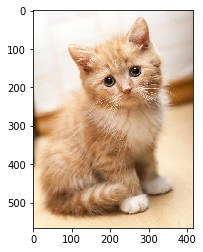

It's a cat: 0.9999915361404419, It's a dog: 8.454015187453479e-06




INFO:tensorflow:Restoring parameters from C:\Users\William\Documents\python\SITL\inception_v3.ckpt
INFO:tensorflow:Restoring parameters from ./testsave
Predict: dog.jpg



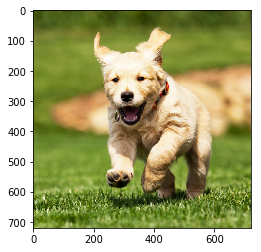

It's a cat: 1.8902601368608885e-05, It's a dog: 0.9999810457229614


In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pred = predict(prediction, 'cat.jpg')
print('Predict: cat.jpg\n', )
img=mpimg.imread('cat.jpg')
imgplot = plt.imshow(img)
plt.show()
print ('It\'s a cat: {}, It\'s a dog: {}'.format(pred[0][0], pred[0][1]))
print('\n\n\n')

pred = predict(prediction, 'dog.jpg')
print('Predict: dog.jpg\n', )
img=mpimg.imread('dog.jpg')
imgplot = plt.imshow(img)
plt.show()
print ('It\'s a cat: {}, It\'s a dog: {}'.format(pred[0][0], pred[0][1]))